In [ ]:
#DOWNLOAD OPEN CV
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#link colab den drive 
# tao thu muc và đẩy image lên để lát đọc ra

Mounted at /content/gdrive


In [2]:
import numpy as np
from google.colab.patches import cv2_imshow
import math
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline


In [214]:
def edge_detection(img, blur_ksize=5, threshold1=100, threshold2=200):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) #covert về ảnh xám để dễ xác định biên
    img_gaussian = cv.GaussianBlur(gray, (blur_ksize, blur_ksize), 0) #lọc gauss để giảm nhiễu
    # cv2_imshow(gray)
    # print(img_gaussian)
    img_canny = cv.Canny(img_gaussian, threshold1, threshold2, 5) #tách biên
    return img_canny

def ConvertToGray(img):
  return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def GaussianBlurFucn(gray, blur_ksize):
  return cv.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

def CannyFunc(img, threshold1, threshold2):
  return cv.Canny(img, threshold1, threshold2, 5)
    
#hàm tính góc dựa trên 2 vecto chỉ phương
def angle(vector1, vector2):
    if vector1 == vector2:
      return 0
    else:
      x1, y1 = vector1
      x2, y2 = vector2
      inner_product = x1*x2 + y1*y2
      len1 = math.hypot(x1, y1)
      len2 = math.hypot(x2, y2)
      return math.acos(inner_product/(len1*len2))

def calculate(pt1, pt2):
    a = angle(pt1, pt2)
    if a == 0:
      return 0
    return abs(math.degrees(a))

In [4]:
cd gdrive/MyDrive/B1-CV

/content/gdrive/MyDrive/B1-CV


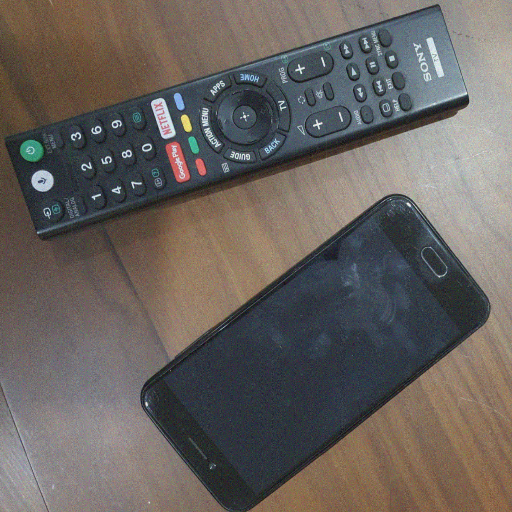

In [268]:
# image = cv.imread('img4.png', 1)
image = cv.imread('img3_bruit.png', 1)
# image = cv.imread('img3_bruit2.png', 1)
# image = cv.imread('img3_add.png', 1)

cv2_imshow(image)

In [269]:
#dua ve anh xam
img = ConvertToGray(image)
# get min and max values of img
img_min, img_max = np.amin(img, (0,1)), np.amax(img, (0,1))
# print(img_min,img_max)

# convert image to floats and do dft saving as complex output
dft = cv.dft(np.float32(img), flags = cv.DFT_COMPLEX_OUTPUT)

# apply shift of origin from upper left corner to center of image
dft_shift = np.fft.fftshift(dft)

# extract magnitude and phase images
mag, phase = cv.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])

# get spectrum
spec = np.log(mag) / 20

# create mask from spectrum keeping only the brightest spots as the notches
mask = cv.normalize(spec, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)
mask = cv.threshold(mask, 0.65, 1, cv.THRESH_BINARY)[1]

# dilate mask
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
mask = cv.morphologyEx(mask, cv.MORPH_DILATE, kernel)

# cover center DC component by circle of black leaving only a few white spots on black background
xcenter = mask.shape[1] // 2
ycenter = mask.shape[0] // 2
mask = cv.circle(mask, (xcenter,ycenter), radius=10, color=0, thickness=cv.FILLED)

# apply mask to magnitude such that magnitude is made zero where mask is one, ie at spots
mag[mask!=0] = 0

# convert new magnitude and old phase into cartesian real and imaginary components
real, imag = cv.polarToCart(mag, phase)

# combine cartesian components into one complex image
back = cv.merge([real, imag])

# shift origin from center to upper left corner
back_ishift = np.fft.ifftshift(back)

# do idft saving as complex output
img_back = cv.idft(back_ishift)

# combine complex components into original image again
img_back = cv.magnitude(img_back[:,:,0], img_back[:,:,1])

# re-normalize to 8-bits in range of original
min, max = np.amin(img_back, (0,1)), np.amax(img_back, (0,1))
# print(min,max)
notched = cv.normalize(img_back, None, alpha=img_min, beta=img_max, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

cv.imwrite("img.png", notched)

img1 = cv.imread('img.png', 1)
edges_newF = edge_detection(img1, 5, 60, 100)


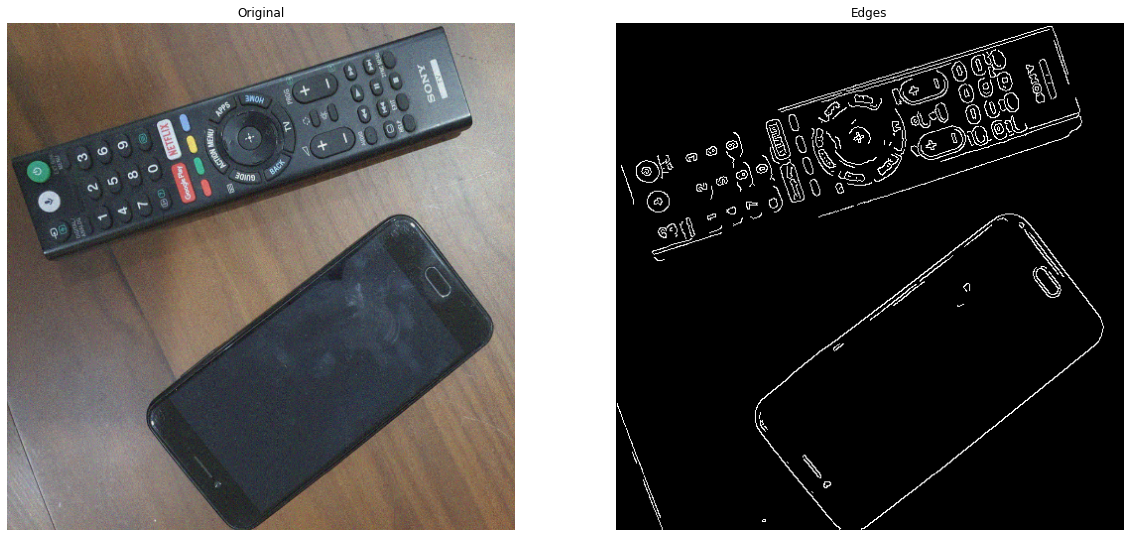

In [270]:
#Ảnh gốc và ảnh sau khi tách biên
f, axarr = plt.subplots(1,2,figsize=(20, 20))
[axi.set_axis_off() for axi in axarr.ravel()]
axarr[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axarr[0].set_title("Original")
axarr[1].imshow(edges_newF, cmap=plt.get_cmap('gray'))
axarr[1].set_title("Edges")
f.show()

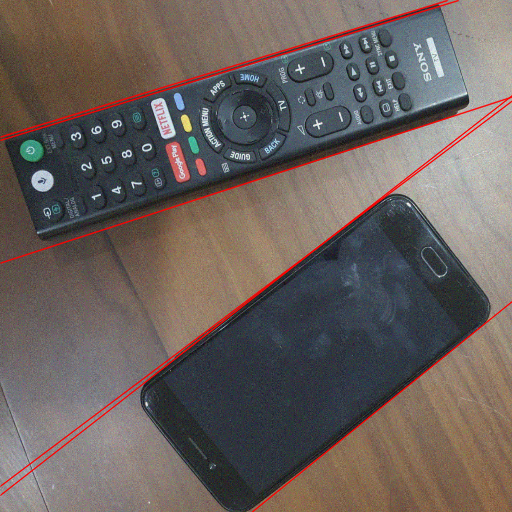

In [271]:
cdst = image.copy()

VTCPs = [] #tap hop vecto chi phuong
lines = cv.HoughLines(edges_newF, 1, np.pi / 180, 150, None, 0, 0) #hàm houghLines để lấy ra các đường thẳng tương ứng với biên
# lines = cv.HoughLinesP(edges_newF, 1, np.pi / 180, 150, None, 150, 10)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a))) #điểm đầu đường thẳng
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a))) #điểm cuối
        VTCPs.append((pt2[0] - pt1[0], pt2[1] - pt1[1])) #tính vtcp và lưu nó vào mảng
        cv.line(cdst, pt1, pt2, (0,0,255), 1, cv.LINE_AA) #vẽ đường thẳng biên màu đỏ lên img gốc đã copy

cv2_imshow(cdst)       


In [272]:
print(VTCPs)
listAngle = []
a = 0
#tính tất cả góc của đôi một vtcp 
for i in range(0, len(VTCPs) - 1):
  for j in range(1, len(VTCPs)):
    if i != j:
      # print(i , j)
      angleTmp = calculate(VTCPs[i], VTCPs[j])
      listAngle.append(angleTmp)

print(listAngle)


[(1554, -1258), (1901, -617), (1575, -1230), (1912, -584), (1597, -1202), (1912, -584)]
[21.009325157673214, 1.0028523169803778, 22.00626151051688, 2.0236351887084223, 22.00626151051688, 20.00647284069264, 0.9969363528436483, 18.985689968964866, 0.9969363528436483, 20.00647284069264, 21.003409193536307, 1.0207828717279899, 21.003409193536307, 0.9969363528436483, 21.003409193536307, 19.982626321808528, 0, 18.985689968964866, 1.0207828717279899, 19.982626321808528, 19.982626321808528]


In [273]:
#lấy gtri max
print(np.max(listAngle))

22.00626151051688
